# Zero-Shot Learning Experiments: Topic classification

Using https://huggingface.co/zero-shot/ 

## 1. Replicate the results from app in code

In [1]:
from transformers import pipeline

In [2]:
classifier = pipeline('zero-shot-classification',
                      model='joeddav/xlm-roberta-large-xnli')

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
sequence = "The Avengers - Hammer Top Besetzung - Top Film endlich war es soweit. Meine Superhelden vereint in einem Film. Ich habe mich besonders auf Robert Downey Jr. und Chris Hemsworth gefreut. Robert stellt Iron Man mit einer Coolness dar, die man nicht überbieten kann. Die Rolle ist perfekt auf ihn zugeschnitten. Chris Hemsworth ist einfach eine Augenweide:-). Loki war auch super. Gegen Mark Ruffalo als Hulk hatte ich meine Bedenken, die wurden dann aber im Film widerlegt. Wenn man die einzelnen Filme vorher gesehen hat und auch die Anspielungen auf 'The Avengers' verstanden hat, ist der Film noch interessanter. Die Story war vorhersehbar, aber trotzdem gut. Was mir am besten gefallen hat, ist das jeder Charakter gleich stark vertreten war. Fazit: Unbedingt anschauen!"
hypothesis_template = 'This text is about {}.' 
labels = "películas, acción, superhéroes, libros"
allow_multi_class = True

In [4]:
result = classifier(sequence, labels,
           hypothesis_template=hypothesis_template,
           multi_class=allow_multi_class)

result

{'sequence': "The Avengers - Hammer Top Besetzung - Top Film endlich war es soweit. Meine Superhelden vereint in einem Film. Ich habe mich besonders auf Robert Downey Jr. und Chris Hemsworth gefreut. Robert stellt Iron Man mit einer Coolness dar, die man nicht überbieten kann. Die Rolle ist perfekt auf ihn zugeschnitten. Chris Hemsworth ist einfach eine Augenweide:-). Loki war auch super. Gegen Mark Ruffalo als Hulk hatte ich meine Bedenken, die wurden dann aber im Film widerlegt. Wenn man die einzelnen Filme vorher gesehen hat und auch die Anspielungen auf 'The Avengers' verstanden hat, ist der Film noch interessanter. Die Story war vorhersehbar, aber trotzdem gut. Was mir am besten gefallen hat, ist das jeder Charakter gleich stark vertreten war. Fazit: Unbedingt anschauen!",
 'labels': ['superhéroes', 'películas', 'acción', 'libros'],
 'scores': [0.9459265470504761,
  0.6354550123214722,
  0.593166172504425,
  0.02965512126684189]}

In [5]:
result["labels"][0], result["scores"][0]

('superhéroes', 0.9459265470504761)

## 2. Apply method to all the sentences from our data

In [150]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
sys.path.append("../../../")
from tasks.data_loader.src.utils import *
from tasks.evaluate_model.src.model_evaluator import *

In [145]:
HYPOTHESIS_TEMPLATE = 'This text is about {}.' 
LABELS = "Direct payment, Tax deduction, Credit/guarantee, Technical assistance, Supplies, Fines, Unknown"

def classify_sentence(sentence, labels, allow_multi_class=False, multi_class_thresh=0.5, all_probs=False):
    result = classifier(sentence, labels,
           hypothesis_template=HYPOTHESIS_TEMPLATE,
           multi_class=allow_multi_class)
    
    if all_probs:
        return result["labels"], result["scores"]
    
    if allow_multi_class:
        multi_labels = []
        multi_scores = []
        for i, score in enumerate(result["scores"]):
            if score > multi_class_thresh:
                multi_labels.append(result["labels"][i])
                multi_scores.append(score)
         
        return multi_labels, multi_scores
    
    return result["labels"][0], result["scores"][0]

def classify_sentences_topic(dataset_map, topics):
    model_preds = []
    scores = []
    for sentence in tqdm(dataset_map.values()):
        model_pred, score = classify_sentence(sentence['text'], topics)
        model_preds.append(model_pred)
        scores.append(score)
        
    return model_preds, scores

In [7]:
# True label: guarantee
classify_sentence("Disminuir los riesgos para el inversionista implementando mecanismos de aseguramiento.", LABELS, True)

(['Credit/guarantee'], [0.8358953595161438])

In [8]:
# True label: direct payment
classify_sentence("Los recursos que el Fondo Forestal Mexicano obtenga por el cobro de bienes y servicios ambientales se entregarán directamente a los proveedores de dichos servicios y una parte se destinará a cubrir los costos de esta operación.", LABELS)

('Direct payment', 0.42551904916763306)

In [9]:
# True label: Tax deduction
classify_sentence("Otorgar incentivos fiscales a las plantaciones forestales comerciales, incluyendo incentivos dirigidos a promover la industria ligada a las plantaciones comerciales forestales.", LABELS)

('Tax deduction', 0.4818664789199829)

### Load labeled sentences from 5 countries (Excel file)

In [18]:
data_excel = pd.read_excel("../input/allcountries_policytags.xlsx", engine="openpyxl", sheet_name=None)

In [20]:
data_excel['Mexico '].head()

,Document,Original Text,"Relevant Sentences (for Environment, Incentives, Land Type)","Relevant Phrases (for Environment, Incentives, Land Type)",Incentive Instrument,Land Use Type,Category,Unique Policy #,Key words
0,2019 ACUERDO por el que se emiten los Lineamie...,Generar empleo y garantizara la población camp...,Generar empleo y garantizara la población camp...,garantizara la población campesina el bienesta...,"Direct payment (PES), Credit, Technical assist...","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),"insumo, crédito, capacitación, asistencia técnica"
1,2019 ACUERDO por el que se emiten los Lineamie...,\nEl Programa incentivará a los sujetos agrari...,\nEl Programa incentivará a los sujetos agrari...,incentivará a los sujetos agrarios a establece...,"Direct payment (PES), Credit, Technical assist...","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),incentivar
2,2019 ACUERDO por el que se emiten los Lineamie...,Los sujetos agrarios beneficiados por el progr...,Los sujetos agrarios beneficiados por el progr...,Los sujetos agrarios beneficiados por el progr...,"Supplies, Technical assistance","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),"apoyo económico, apoyos en especie, insumos, h..."
3,2019 ACUERDO por el que se emiten los Lineamie...,"El sujeto de derecho, recibirá un apoyo económ...","El sujeto de derecho, recibirá un apoyo económ...","recibirá un apoyo económico de $5,000.00 (Cin...",Direct payment (PES),"Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),pesos
4,2019 ACUERDO por el que se emiten los Lineamie...,"El sujeto de derecho, recibirá en especie las ...","El sujeto de derecho, recibirá en especie las ...",recibirá en especie las plantas necesarias par...,Supplies,"Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),recibir


In [22]:
countries_sents_map = {}
mexico_df = data_excel['Mexico ']
mexico_df["Relevant Sentences (for Environment, Incentives, Land Type) "]

0      Generar empleo y garantizara la población camp...
1      \nEl Programa incentivará a los sujetos agrari...
2      Los sujetos agrarios beneficiados por el progr...
3      El sujeto de derecho, recibirá un apoyo económ...
4      El sujeto de derecho, recibirá en especie las ...
                             ...                        
98     Quienes aprovechen tierras de pastoreo y opten...
99     De los apoyos e incentivos;\n La Secretaría fo...
100    Generación y transferencia de tecnologías, for...
101    Los municipios y las delegaciones de las depen...
102    El Ejecutivo Federal, por conducto de las Secr...
Name: Relevant Sentences (for Environment, Incentives, Land Type) , Length: 103, dtype: object

In [29]:
mexico_df["Relevant Sentences (for Environment, Incentives, Land Type) "] = mexico_df["Relevant Sentences (for Environment, Incentives, Land Type) "].apply(lambda x: x.replace("\n", "").strip())

In [46]:
mexico_sents = list(mexico_df["Relevant Sentences (for Environment, Incentives, Land Type) "])

In [37]:
mexico_df['Incentive Instrument'] = mexico_df['Incentive Instrument'].apply(lambda x: x.replace("(PES)", "").replace("(Bond)", "").strip())

In [45]:
mexico_labels = [[string.strip() for string in label.split(", ")][0] for label in mexico_df['Incentive Instrument']]

In [126]:
mexico_sents[0], set(mexico_labels)

('Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica;',
 {'Credit',
  'Direct payment',
  'Fine',
  'Guarantee',
  'Supplies',
  'Tax deduction',
  'Technical assistance',
  'Unknown'})

In [121]:
def country_labeled_sentences(excel_map):
    result = {}
    for country, dataframe in excel_map.items():

        new_sents_col = dataframe["Relevant Sentences (for Environment, Incentives, Land Type) "].dropna()
        new_labels_col= dataframe["Incentive Instrument"].dropna()
        
        sentences = list(new_sents_col.apply(lambda x: x.replace("\n", "").strip()))
        label_col = new_labels_col.apply(lambda x: x.replace("(PES)", "").replace("(Bond)", "").strip())
        labels = [[string.strip() for string in label.split(", ")][0] for label in label_col]
        result[country] = {}

        for i, (sent, label) in enumerate(zip(sentences, labels)):
            if i not in result[country]:
                result[country][i] = {"text": sent, "labels": [label]}
            else:
                result[country][i]["text"] = sent
                result[country][i]["labels"] = [label]

    return result

In [122]:
excel_sents_map = country_labeled_sentences(data_excel)

## 2.1 Sentence analysis by country

### 2.1.1 Mexico

In [123]:
excel_sents_map["Mexico "][0]

{'text': 'Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica;',
 'labels': ['Direct payment']}

In [ ]:
label_names = ["Direct payment", "Tax deduction", "Credit", "Guarantee", "Technical assistance", "Supplies", "Fine", "Unknown"]

#### We want to have the labels both as numbers and as text (for plotting/evaluating purposes)

In [128]:
mexico_labels = labels_from_model_output(excel_sents_map["Mexico "])
num_mexico_labels = labels_to_numeric(mexico_labels, label_names)

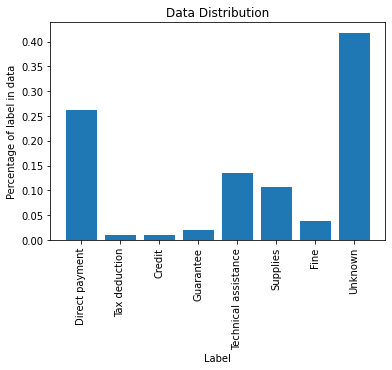

Label counts:
{'Direct payment': 0.2621359223300971, 'Tax deduction': 0.009708737864077669, 'Credit': 0.009708737864077669, 'Guarantee': 0.019417475728155338, 'Technical assistance': 0.13592233009708737, 'Supplies': 0.10679611650485436, 'Fine': 0.038834951456310676, 'Unknown': 0.4174757281553398}


In [130]:
plot_data_distribution(num_mexico_labels, label_names)

In [146]:
preds, scores = classify_sentences_topic(excel_sents_map["Mexico "], label_names)

100%|██████████| 103/103 [10:32<00:00,  6.14s/it]


In [149]:
num_preds = labels_to_numeric(preds, label_names)
preds[:10], scores[:10], num_preds[:10]

(['Guarantee',
  'Fine',
  'Fine',
  'Fine',
  'Guarantee',
  'Supplies',
  'Technical assistance',
  'Technical assistance',
  'Supplies',
  'Fine'],
 [0.29646289348602295,
  0.24384066462516785,
  0.3148803114891052,
  0.1774168163537979,
  0.36781013011932373,
  0.5200287699699402,
  0.2447296679019928,
  0.2410212755203247,
  0.2889437973499298,
  0.3059084117412567],
 [3, 6, 6, 6, 3, 5, 4, 4, 5, 6])

In [151]:
evaluator = ModelEvaluator(label_names)

Stored confusion matrix: ../output/multi_class_test_cm.png


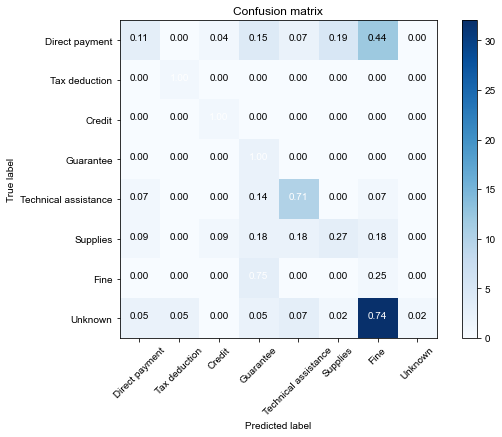

Stored results: ../output/multi_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Direct payment,0.43,0.11,0.95,0.18
Tax deduction,0.33,1,0.98,0.5
Credit,0.33,1,0.98,0.5
Guarantee,0.13,1,0.87,0.24
Technical assistance,0.59,0.71,0.92,0.65
Supplies,0.33,0.27,0.93,0.3
-----,-----,-----,-----,-----
Fine,0.02,0.25,0.53,0.04
Unknown,1,0.02,1,0.05
Macro avg,0.4,0.55,0.9,0.31


In [152]:
evaluator.evaluate(num_mexico_labels, num_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="multi_class_test")

Stored Precision-Recall Curve: ../output/mexico_multi_class_test_prc.png


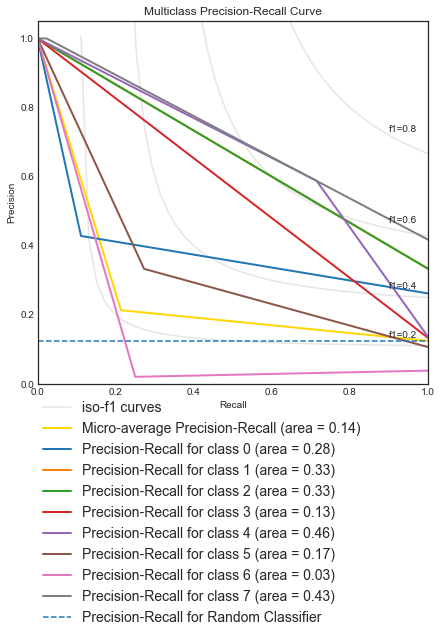

In [153]:
evaluator.plot_precision_recall_curve(num_mexico_labels, num_preds, bin_class=False, all_classes=True, store=True, exp_name="../output/mexico_multi_class_test")

### Load labeled sentences from 5 countries (JSON file)

In [186]:
fname = "../input/allcountries_tagged_sents.json"
# fname = "../input/tagged_sentences_all.json"
data = load_file(fname)

In [187]:
data

{'2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Sembrando Vida': {'Seccion unica': {'tags': [],
   'sentences': {'1': {'text': 'Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica',
     'labels': ['Direct payment (PES)', 'Credit', 'Technical assistance']},
    '2': {'text': 'El Programa incentivará a los sujetos agrarios a establecer sistemas productivos agroforestales, el cual combina la producción de los cultivos tradicionales en conjunto con árboles frutícolas y maderables, y el sistema de Milpa Intercalada entre Árboles Frutales (MIAF), con lo que se contribuirá a generar empleos, se incentivará la autosuficiencia alimentaria, se mejorarán los ingresos de las y los pobladores y se recuperará la cobertu

### Filter out badly parsed sentences - with 1 character or empty

In [188]:
missing_ids = []
for document, content in data.items():
    for section in content.values():
        for sid, sentence in section['sentences'].items():
            if 0 <= len(sentence['text']) <= 1:
                print(sentence['text'])
                missing_ids.append(sid)

print(len(missing_ids))

0


In [13]:
def remove_sents_from_dataset(ids, dataset):
    filtered_dataset = {}
    
    for docid, document in dataset.items():
        filtered_dataset[docid] = {}
        for secid, section in document.items():
            filtered_dataset[docid][secid] = {}
            filtered_dataset[docid][secid]['tags'] = section['tags']
            filtered_dataset[docid][secid]['sentences'] = {}
            for sentid, sentence in section['sentences'].items():
                if sentid not in ids:
                    filtered_dataset[docid][secid]['sentences'][sentid] = sentence
            
    return filtered_dataset

In [14]:
dataset = remove_sents_from_dataset(missing_ids, data)

In [189]:
dataset_map = labeled_sentences_from_dataset(data)

In [190]:
dataset_map['10']

{'text': 'El sujeto de derecho recibirá en especie los insumos necesarios para desarrollar el programa agroforestal en su unidad de producción, los cuales podrán variar de acuerdo al tipo de cultivo a establecerse en cada territorio, considerando la vocación productiva de la región, la pertinencia cultural y la perspectiva de género',
 'labels': ['Supplies']}

### 3. Binary classification

In [191]:
labels = labels_from_dataset(data)

In [193]:
label_names = ["not incentives", "incentives"]
binary_labels = list(map(lambda x: "incentives" if x != "Unknown" else "not incentives", labels))

In [194]:
binary_labels.count("incentives"), binary_labels.count("not incentives")

(938, 346)

In [195]:
num_bin_labels = labels_to_numeric(binary_labels, label_names)

In [196]:
num_bin_labels[180:190]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

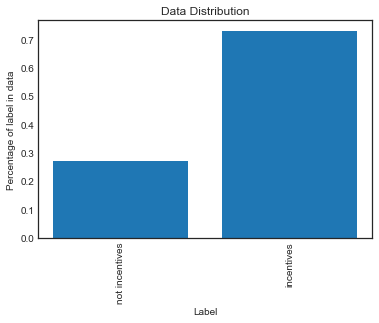

Label counts:
{'not incentives': 0.26947040498442365, 'incentives': 0.7305295950155763}


In [197]:
plot_data_distribution(num_bin_labels, label_names)

In [198]:
bin_model_preds, bin_scores = classify_sentences_topic(dataset_map,label_names)

 10%|▉         | 124/1284 [01:41<15:52,  1.22it/s]


KeyboardInterrupt: 

In [29]:
bin_preds = labels_to_numeric(bin_model_preds, label_names)
bin_preds[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [31]:
evaluator = ModelEvaluator(label_names)

In [33]:
evaluator.update(num_bin_labels, bin_preds)
print("Recall per class:", evaluator.recall)
print("Average weighted precision:", evaluator.avg_precision[1])

Recall per class: [0.01204819 0.94117647]
Average weighted precision: 0.540917487684729


Stored confusion matrix: ../output/binary_class_test_cm.png


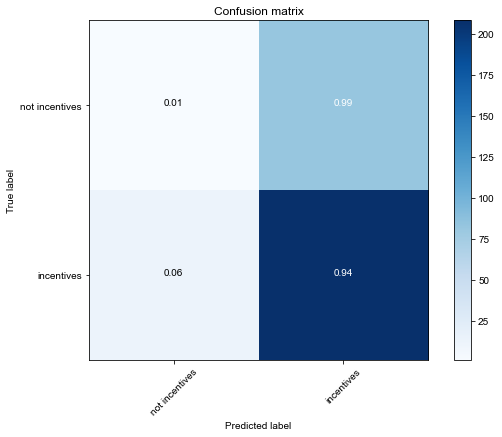

Stored results: ../output/binary_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
not incentives,0.07,0.01,0.94,0.02
incentives,0.72,0.94,0.01,0.81
Macro avg,0.39,0.48,0.48,0.42
Weighted avg,0.54,0.69,0.27,0.6
Accuracy,-----,-----,-----,0.6875
-----,-----,-----,-----,-----


In [34]:
evaluator.evaluate(num_bin_labels, bin_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="binary_class_test")

In [ ]:
evaluator.plot_precision_recall_curve(num_bin_labels, bin_scores, bin_class=True, store=True, exp_name="binary_class_test")

### 4. Multi-class classification

In [51]:
label_names = ["Direct payment", "Tax deduction", "Credit", "Guarantee", "Technical assistance", "Supplies", "Fine", "Unknown"]

In [52]:
multi_model_preds, multi_scores = classify_sentences_topic(dataset_map, label_names)

100%|██████████| 304/304 [12:58<00:00,  2.56s/it]


In [53]:
evaluator = ModelEvaluator(label_names)

In [59]:
multi_model_preds[:10], labels[:10]

(['Guarantee',
  'Fine',
  'Guarantee',
  'Fine',
  'Fine',
  'Technical assistance',
  'Fine',
  'Credit',
  'Guarantee',
  'Unknown'],
 ['Direct payment (PES)',
  'Direct payment (PES)',
  'Supplies',
  'Supplies',
  'Supplies',
  'Supplies',
  'Direct payment (PES)',
  'Direct payment (PES)',
  'Supplies',
  'Supplies'])

In [54]:
# Make label names from dataset match label names from prediction (a.k.a make all Direct payments be the same)
updated_labels = []
for label in labels:
    if "(" in label:
        updated_labels.append("Direct payment")
    else:
        updated_labels.append(label)

In [55]:
num_multi_labels = labels_to_numeric(updated_labels, label_names)
num_multi_preds = labels_to_numeric(multi_model_preds, label_names)

Stored confusion matrix: ../output/multi_class_test_cm.png


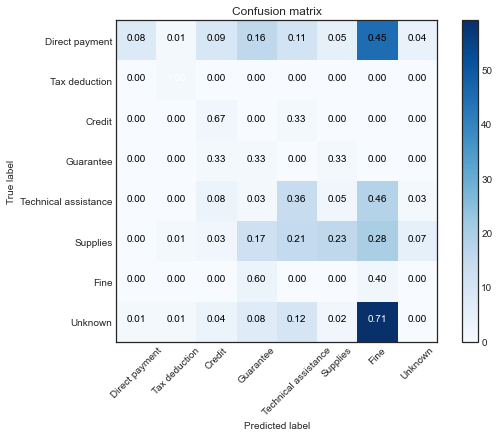

Stored results: ../output/multi_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Direct payment,0.89,0.08,1,0.15
Tax deduction,0.25,1,0.99,0.4
Credit,0.1,0.67,0.94,0.17
Guarantee,0.03,0.33,0.87,0.05
Technical assistance,0.27,0.36,0.86,0.31
Supplies,0.62,0.23,0.96,0.33
-----,-----,-----,-----,-----
Fine,0.01,0.4,0.53,0.03
Unknown,0,0,0.95,0
Macro avg,0.27,0.38,0.89,0.18


In [56]:
evaluator.evaluate(num_multi_labels, num_multi_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="multi_class_test")

Stored Precision-Recall Curve: multi_class_test_prc.png


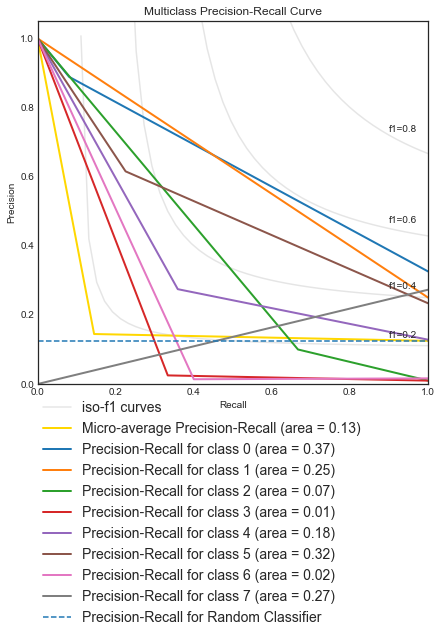

In [57]:
evaluator.plot_precision_recall_curve(num_multi_labels, num_multi_preds, bin_class=False, all_classes=True, store=True, exp_name="multi_class_test")

### Tangent: Separate mutliple labels into a list from JSON file

In [70]:
import json

In [178]:
with open("../input/tagged_sentences_all.json", "r") as fjson: 
    jsents = json.load(fjson)

In [179]:
len(jsents), jsents.keys()

(69,
 dict_keys(['2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Sembrando Vida', '2020 ACUERDO por el que se emiten las Reglas de Operación del Programa Sembrando Vida, para el ejercicio fiscal 2020', 'Sembrando Vida Brochure', '2020 AVANCES Y RETOS DEL PROGRAMA CRÉDITO GANADERO A LA PALABRA', '2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Crédito Ganadero a la Palabra', '2020 REGLAS de Operación del Programa Apoyos para el Desarrollo Forestal Sustentable', '2018 LEY GENERAL DE DESARROLLO FORESTAL SUSTENTABLE', '2013 LEY AMBIENTAL PARA EL DESARROLLO SUSTENTABLE DEL ESTADO DE MICHOACÁN DE OCAMPO', 'Programa Estratégico Forestal para México 2025', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓNAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓN\nAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2007 Decreto Nº 223 -

In [199]:
sentence_tags_dict = {}
new_json = {}

for keydoc, document in jsents.items():
    new_json[keydoc] = {}
    for keysec, section in document.items():
        new_json[keydoc][keysec] = {}
        new_json[keydoc][keysec]['tags'] = section['tags']
        new_json[keydoc][keysec]['sentences'] = {}
        for sentid, sentence in section['sentences'].items():
            new_labels = [label.strip() for label in sentence['labels'].split(", ")]

            updated_labels = []
            for label in new_labels:
                if "(" in label:
                    updated_labels.append("Direct payment")
                else:
                    updated_labels.append(label)
            new_json[keydoc][keysec]['sentences'][sentid] = {'text': sentence['text'], 'labels': updated_labels}

In [200]:
len(new_json), new_json.keys()

(69,
 dict_keys(['2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Sembrando Vida', '2020 ACUERDO por el que se emiten las Reglas de Operación del Programa Sembrando Vida, para el ejercicio fiscal 2020', 'Sembrando Vida Brochure', '2020 AVANCES Y RETOS DEL PROGRAMA CRÉDITO GANADERO A LA PALABRA', '2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Crédito Ganadero a la Palabra', '2020 REGLAS de Operación del Programa Apoyos para el Desarrollo Forestal Sustentable', '2018 LEY GENERAL DE DESARROLLO FORESTAL SUSTENTABLE', '2013 LEY AMBIENTAL PARA EL DESARROLLO SUSTENTABLE DEL ESTADO DE MICHOACÁN DE OCAMPO', 'Programa Estratégico Forestal para México 2025', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓNAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓN\nAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2007 Decreto Nº 223 -

In [201]:
with open("allcountries_tagged_sents.json", "w") as wjson:
    json.dump(new_json, wjson)

In [202]:
data = load_file("allcountries_tagged_sents.json")

In [203]:
dataset_map = labeled_sentences_from_dataset(data)

In [204]:
dataset_map['1']

{'text': 'Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica',
 'labels': ['Direct payment', 'Credit', 'Technical assistance']}

In [206]:
dataset_labels = labels_from_dataset(data)
dataset_labels[:10], set(dataset_labels)

(['Direct payment',
  'Direct payment',
  'Supplies',
  'Supplies',
  'Supplies',
  'Supplies',
  'Direct payment',
  'Direct payment',
  'Supplies',
  'Supplies'],
 {'Credit',
  'Credit/guarantee',
  'Direct payment',
  'Fine',
  'Guarantee',
  'Other',
  'Supplies',
  'Tax credit',
  'Tax deduction',
  'Technical assistance',
  'Unknown'})

In [69]:
numeric_labels = numeric_labels_from_dataset(data)
numeric_labels[:10]

[3, 3, 6, 6, 6, 6, 3, 3, 6, 6]